In [155]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import Series

from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import LSTM, TimeDistributed


## Load the stock data

### Choose CSV file of the company stock price

In [156]:
! ls

Amazon.csv  Apple.csv  Facebook.csv


In [157]:
import os
os.chdir(path)
arr = os.listdir()
arr

['Facebook.csv', 'Amazon.csv', 'Apple.csv']

In [158]:
import glob

path =r'/home/aurobindo/Stock_prices/files'
filenames = glob.glob(path + "/*.csv")

In [159]:
glob.glob(path +"/*.csv")

['/home/aurobindo/Stock_prices/files/Facebook.csv',
 '/home/aurobindo/Stock_prices/files/Amazon.csv',
 '/home/aurobindo/Stock_prices/files/Apple.csv']

In [160]:
arr[0][:-4]

'Facebook'

In [161]:
dfs = []
for index,filename in enumerate(filenames):
    df = pd.read_csv(filename)
    
    close_name = 'Close_' + arr[index][:-4]
    col_names = ['Timestamp','Sequence','Open','High','Low',close_name,'Volume']
    df.columns = col_names
    df['Timestamp'] =  pd.to_datetime(df['Timestamp'],format='%Y-%m-%d %H:%M:%S')
    df.index = df['Timestamp']
    df = df.drop(['Sequence','Timestamp'],axis =1)
    
    df = df[[close_name]]
    df = df.loc['2018-03-14']
    
    dfs.append(df)

In [162]:
len(dfs)

3

In [163]:
arr

['Facebook.csv', 'Amazon.csv', 'Apple.csv']

In [164]:
result = pd.concat(dfs, axis=1)
result.shape

(391, 3)

In [165]:
result.head(1)

,Close_Facebook,Close_Amazon,Close_Apple
Timestamp,,,
2018-03-14 13:30:00,182.6,1597.0,180.32


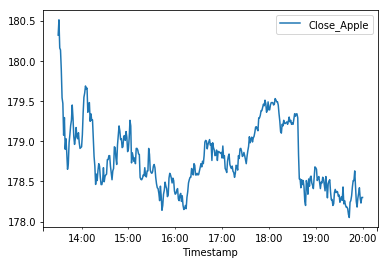

In [166]:
result.iloc[:, [2]].plot()

<Figure size 1080x576 with 0 Axes>

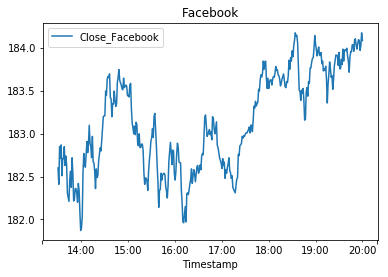

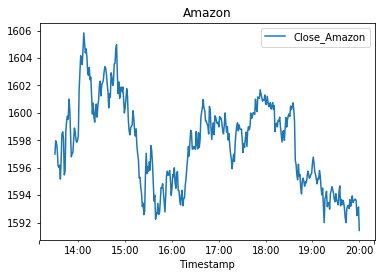

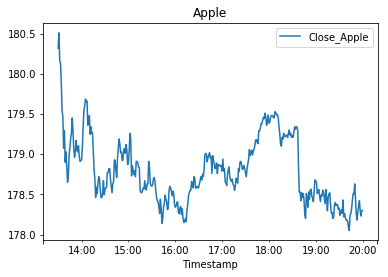

In [167]:
plt.figure(figsize=(15,8))

for i in range(len(dfs)):
    #plt.subplot(i,1,1)
    result.iloc[:, [i]].plot()
    plt.title(arr[i][:-4])


plt.legend()
plt.show()

In [168]:
train_data =result.iloc[:-50]
train_data.shape

(341, 3)

In [169]:
test_data = result.iloc[-50:]
test_data.shape

(50, 3)

In [170]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [171]:
result.iloc[:, [2]].head()

,Close_Apple
Timestamp,
2018-03-14 13:30:00,180.320
2018-03-14 13:31:00,180.510
2018-03-14 13:32:00,180.160
2018-03-14 13:33:00,180.135
2018-03-14 13:34:00,179.890


In [172]:
trains,train_scaleds,tests,test_scaleds  = [],[],[],[]

for i in range(len(dfs)):
    series = result.iloc[:, [i]]
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    supervised = timeseries_to_supervised(diff_values, 4)
    supervised_values = supervised.values
    train, test = supervised_values[0:-100], supervised_values[-100:]
    
    trains.append(train)
    tests.append(test)
    
    scaler, train_scaled, test_scaled = scale(train, test)
    train_scaleds.append(train_scaled)
    test_scaleds.append(test_scaled)

/home/aurobindo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [173]:
merge_train = np.insert(trains[0][:,:-1],[4],trains[1][:,:-1], axis=1)
merge_test = np.insert(tests[0][:,:-1],[4],tests[1][:,:-1], axis=1)

for i in range(len(dfs)-2):
    merge_train = np.insert(merge_train,[4 * (i+2)],trains[i+2][:,:-1], axis=1)
    merge_test  = np.insert(merge_test,[4 * (i+2)],tests[i+2][:,:-1], axis=1)
    

In [174]:
print(merge_train.shape)
print(merge_test.shape)

(290, 12)
(100, 12)


In [175]:
l_trains = []
l_tests = []
for i in range(len(dfs)):

    l_train = trains[i][:,-1].reshape(trains[i][:,-1].shape[0],1)
    l_test = tests[i][:,-1].reshape(tests[i][:,-1].shape[0],1)
    l_trains.append(l_train)
    l_tests.append(l_test)

In [176]:
merge_train_output = np.concatenate(tuple(l_trains),axis=1)
merge_test_output = np.concatenate(tuple(l_tests),axis=1)

In [177]:
print(merge_train_output.shape)
print(merge_test_output.shape)

(290, 3)
(100, 3)


In [178]:
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

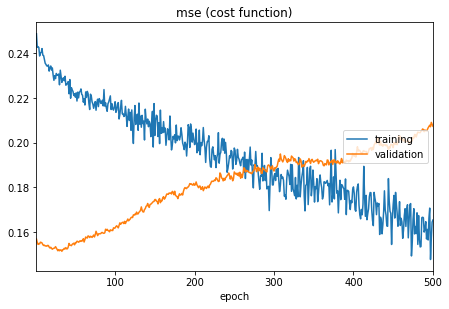

In [247]:
X, y = merge_train, merge_train_output
X = X.reshape(X.shape[0], 1, X.shape[1])
y = y.reshape(y.shape[0], 1, y.shape[1])

X_test, y_test = merge_test, merge_test_output
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])



model = Sequential()

'''
model.add(LSTM(12, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=False,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(18,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(8,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3))
model.add(Activation('linear'))

'''

dim_in = 12
dim_out = len(dfs)
nb_units = 15


model.add(LSTM(input_shape=(1, dim_in),
                    return_sequences=True, 
                    units=nb_units))

model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model.compile(loss = 'mse', optimizer = 'rmsprop')

#print(X.shape)
history = model.fit(X, y, epochs = 500, batch_size = 1,verbose=0,validation_data=(X_test, y_test),callbacks=[plot_losses])
              
              
#model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

#for i in range(500):
#print("Completed :",i+1,"/",500, "Steps")
#model.fit(X, y, epochs=500, batch_size=1, verbose=0, shuffle=False,callbacks=[plot_losses])
#model.reset_states()

In [248]:
def forecast_lstm(model, X):
    y = model.predict(X)
    return y

ts = []
base_values = []

for i in range(len(dfs)):
    t = merge_train[-1:,4*i : 4*(i+1)]
    ts.append(t)
    base_values.append(result.iloc[290][i])

predictions = []

pred_apple = []
pred_amazon = []
pred_facebook = []

prediction = np.zeros((100,3))
prediction_i = np.zeros((100,3))

for i in range(100):
    
    temp = []
    for j in range(len(dfs)):
        temp.append(ts[j][:,i:])
    
    test_pred = np.concatenate(tuple(temp),axis=1)
    input_data = test_pred.reshape(1, 1, 4 *  len(dfs))
    
    y = forecast_lstm(model,input_data)
    prediction[i] = y[0]
    
    ys =[]
    
    for k in range(len(dfs)):
        ts[k] = np.insert(ts[k],[i+4],y[0][0][k], axis=1)
        
        temp = base_values[k] + y[0][0][k]
        prediction_i[i][k] = temp
    #print(y1, y2, y3)
    #print(y1, y2, y3)
    
   
    #print("t",t1,t2,t3)
    
    
    #red_apple.append(tem1)
    #red_amazon.append(tem2)
    #red_facebook.append(tem3)
    
sqrt(mean_squared_error(merge_test_output, prediction))    

0.39639766557086215

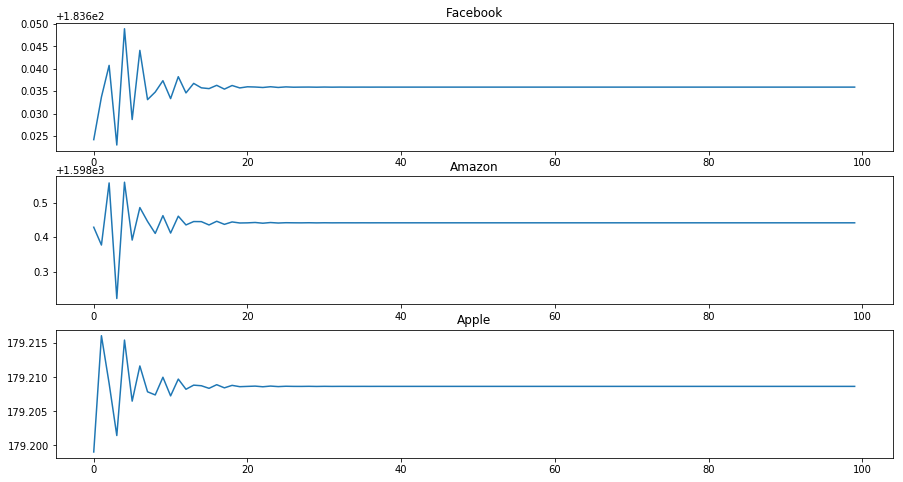

In [249]:
plt.figure(figsize=(15,8))
for i in range(len(dfs)):
    plt.subplot(3,1,i+1)
    plt.plot(prediction_i[:,i])
    plt.title(arr[i][:-4])
plt.show()   

# Parallal Process